### IMDB

Performing NLP on the IMDB movie review data.

In [0]:
from fastai.text import *

Preparing the data

First let's download the dataset. 


The dataset has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [5]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

In [3]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


Lets look at the first review.

In [4]:
df['text'][0]

"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!"

The dataframe contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:


In [6]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')



By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A TextDataBunch does all of that behind the scenes for you.

Let's take the time to save the things that were calculated.


In [0]:
data_lm.save()

In [0]:
data = load_data(path)

In [9]:
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive



Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token UNK.

The correspondance from ids to tokens is stored in the vocab attribute of our datasets, in a dictionary called itos (for int to string).


In [10]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']



And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:


In [0]:
data.train_ds[0][0]

Text xxbos xxmaj highly enjoyable , very imaginative , and xxunk xxunk all rolled into one , xxmaj stardust tells the story of a young man living outside a fantasy world going inside it to retrieve a bit of a fallen star only to find the star is alive , young , and beautiful . a kingdom whose king is about to die has said king xxunk a competition on his several sons to see who can retrieve a ruby first to be king whilst a trio of witches want the star to xxunk up and use to keep them young . xxmaj these three plot threads xxunk xxunk together throughout the entire picture blended with good acting , dazzling special effects , and some solid sentiment and humour as well . xxmaj stardust is a fun film and has some fun performances from the likes of xxmaj claire xxmaj danes as the xxunk could gaze at her for quite some time ) to xxmaj michelle xxunk could gaze at her at full magical powers even longer ) playing the horrible witch to xxmaj robert xxmaj deniro playing a nancy - boy air pirat

But the underlying data is all numbers.

In [0]:
data.train_ds[0][0].data[:10]

array([   2,    5,  537,  686,   10,   70, 3811,   10,   12,    0])


With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.


Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.


In [0]:
bs=48

In [12]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm')]

In [13]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat')]



The reviews are in a training and test set following an imagenet structure. The only difference is that there is an unsup folder on top of train and test that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called wikitext-103). That model has been trained to guess what the next word is, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [14]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')



We have to use a special kind of TextDataBunch for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.


In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [16]:
data_lm.show_batch()

idx,text
0,"the video flows as smoothly and artfully as the production itself . a wonderful experience . xxbos i have been watching xxmaj king of xxmaj queens from the beginning , and have felt it is overlooked at the award shows . xxmaj this show has the best humor , you can identify with the characters , we talk about it at work a lot , because i work at a"
1,makes a great adult who you really want to ' get ' . xxmaj my 13 year old daughter and her friend loved it . xxmaj parents : xxmaj no really bad words or any sex to worry about . xxmaj recommend it for the ' right ' crowd . xxup ap xxbos xxmaj ali g earned his fame on the small screen - though the big screen has not
2,"the xxmaj mormons heading west who often xxunk to his sinning days by cussing only to be called down by fellow xxmaj mormon xxmaj adam xxmaj perkins ( xxmaj russell xxmaj simpson ) . xxmaj when any bothersome situation arises xxmaj elder xxmaj wiggs ( xxmaj ward xxmaj bond ) yells , "" xxmaj blow your horn , xxmaj sister xxmaj xxunk ! "" xxmaj the xxmaj mormon sister ,"
3,"there 's self - awareness , with the lead addressing you , personally , and , for example , explaining why he is n't going to do what you just asked him to . xxmaj there are references to pop culture through a couple of decades . xxmaj almost all of it works , hardly any gags fall flat , and if you are n't in stitches during this ,"
4,"xxmaj if you 're looking for an amazing film in the realm of great production value , good or even mediocre acting , and good special effects ... this is xxup not that movie . xxmaj if you 're looking for laughs and timeless wonderment , pick this up for a dollar and you 'll probably never let it go . xxmaj with friends , popcorn and drinks , it"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in ~/.fastai/models/ (or elsewhere if you specified different paths in your config file).

In [17]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [18]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


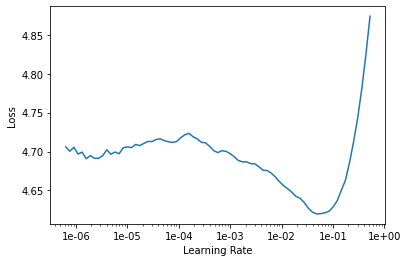

In [19]:
learn.recorder.plot(skip_end=15)

In [20]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.135806,4.020599,0.295789,26:06


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [0]:
learn.unfreeze()

In [24]:
learn.fit_one_cycle(10, 1e-3, moms = (0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.868394,3.838655,0.314170,26:23
1,3.843316,3.797769,0.320658,26:21
2,3.814430,3.771610,0.324313,26:29
3,3.760246,3.739798,0.328111,26:28
4,3.730964,3.714898,0.330975,26:30
5,3.666791,3.692590,0.334061,26:29
6,3.619142,3.675663,0.335930,26:24
7,3.602154,3.665918,0.337614,26:20
8,3.533510,3.661725,0.338264,26:21
9,3.552087,3.661673,0.338378,26:16


In [0]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [28]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because it 's a little dark , because that 's exactly what i want to see . The Director , the Director , the Screenwriter , Director , and the Writers are going for the
I liked this movie because it has a history of American history and the history of the Soviet revolution . The movie is not based on Moore 's book , it is a book , i think from the beginning to


In [30]:
learn.predict(TEXT,N_WORDS, temperature=0.75)

"I liked this movie because there was a lot of swearing . i was n't sure what the movie was about when it came out . It was about 3 people and that is about the only reason i gave it a 4 ."

We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.


In [0]:
learn.save_encoder('fine_tuned_enc')

### Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.


In [0]:
path = untar_data(URLs.IMDB)

In [37]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [39]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj some have praised _ xxunk _ as a xxmaj disney adventure for adults . i do n't think so -- at least not for thinking adults . \n \n xxmaj this script suggests a beginning as a live - action movie , that struck someone as the type of crap you can not sell to adults anymore . xxmaj the "" crack staff "" of many older",neg
"xxbos xxmaj heavy - handed moralism . xxmaj writers using characters as mouthpieces to speak for themselves . xxmaj predictable , plodding plot points ( say that five times fast ) . a child 's imitation of xxmaj britney xxmaj spears . xxmaj this film has all the earmarks of a xxmaj lifetime xxmaj special reject . \n \n i honestly believe that xxmaj jesus xxmaj xxunk and xxmaj",neg
"xxbos i saw this movie during a xxmaj tolkien - themed xxmaj interim class during my sophomore year of college . i was seated unfortunately close to the screen and my professor chose me to serve as a whipping boy- everyone else was laughing , but they were n't within constant eyesight . \n \n xxmaj let 's get it out of the way : the xxmaj peter xxmaj",neg
"xxbos xxmaj after reading the previous comments , i 'm just glad that i was n't the only person left confused , especially by the last 20 minutes . xxmaj john xxmaj carradine is shown twice walking down into a grave and pulling the lid shut after him . i anxiously awaited some kind of explanation for this odd behavior ... naturally i assumed he had something to do with",neg


In [40]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj robert xxmaj wuhl is teaching a class of film students at xxmaj new xxmaj york xxmaj university in xxmaj manhattan , xxmaj new xxmaj york . 
 
  xxmaj he covers fallacies of history and truths that are no longer generally known . i would like to see much more of this show . xxmaj it is very entertaining . xxmaj mr. xxmaj wuhl uses examples and " show and tell " to get his points across . xxmaj he explained that the person who actually rode the xxmaj midnight xxmaj ride of xxmaj paul xxmaj revere was not xxmaj paul xxmaj revere ! xxmaj henry xxmaj xxunk xxmaj longfellow used xxmaj revere 's name because it sounded better . 
 
  i 've watched xxmaj robert xxmaj wuhl for many years , from the time he was doing stand - up comedy and all the way through " xxmaj xxunk " on xxup hbo . xxmaj he 's a good actor and a good stand - up comedian , but he 's an excellent teacher ! i highly recommend that you w

In [41]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


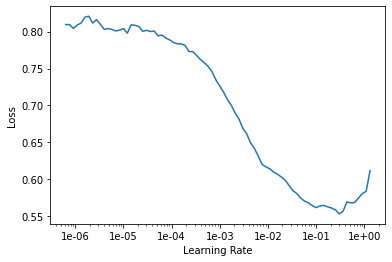

In [42]:
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.318771,0.256389,0.895480,05:44


In [0]:
learn.save('first')

In [0]:
learn.load('first');

In [49]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.266546,0.219501,0.911640,05:47


In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [52]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.238171,0.184296,0.930080,05:32


In [0]:
learn.save('third')

In [0]:
learn.load('third');

In [55]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.206948,0.176229,0.932720,06:03
1,0.184330,0.171287,0.933880,06:15


In [56]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([2.4564e-05, 9.9998e-01]))

In [57]:
learn.predict("I movie was legit!")

(Category pos, tensor(1), tensor([0.3111, 0.6889]))

In [58]:
learn.predict("I movie was bad.")

(Category neg, tensor(0), tensor([0.9958, 0.0042]))

In [59]:
learn.predict("I movie was at a next level.")

(Category pos, tensor(1), tensor([0.4842, 0.5158]))